# 2D Motion Tracking with Kalman Filter

This notebook demonstrates the **steady-state Kalman filter** for tracking a moving object in 2D space from **noisy position measurements**.

## System model

We use a **constant-velocity model** in 2D. The state vector contains position and velocity for each axis:

$$x = \begin{bmatrix} p_x \\ p_y \\ v_x \\ v_y \end{bmatrix}$$

**State transition** (constant velocity, no acceleration):

$$x(n+1) = \begin{bmatrix} 1 & 0 & dt & 0 \\ 0 & 1 & 0 & dt \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} x(n)$$

**Observation** (we only measure position, not velocity):

$$y(n) = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \end{bmatrix} x(n) + \text{noise}$$

In [67]:
import numpy
import matplotlib.pyplot as plt

import AILibs

rng = numpy.random.default_rng(42)

## 1. Generate a 2D trajectory

A realistic trajectory with straight-line segments, curves, and direction changes — simulating an object moving through space.

In [68]:
dt = 0.1  # time step (seconds)

# build trajectory piecewise: straight → turn → straight → curve → stop
segments = []

# segment 1: move right (2s)
n1 = 20
vx, vy = 5.0, 0.0
for _ in range(n1):
    segments.append([vx, vy])

# segment 2: gradual turn upward (3s)
n2 = 30
for i in range(n2):
    angle = numpy.pi / 2 * (i / n2)
    speed = 5.0
    segments.append([speed * numpy.cos(angle), speed * numpy.sin(angle)])

# segment 3: move up (2s)
n3 = 20
for _ in range(n3):
    segments.append([0.0, 5.0])

# segment 4: circular arc (4s)
n4 = 40
radius = 3.0
for i in range(n4):
    angle = numpy.pi / 2 + numpy.pi * (i / n4)
    segments.append([radius * 2 * numpy.cos(angle), radius * 2 * numpy.sin(angle)])

# segment 5: decelerate and stop (2s)
n5 = 20
for i in range(n5):
    factor = 1.0 - i / n5
    segments.append([-4.0 * factor, -2.0 * factor])

velocities = numpy.array(segments)
n_steps = len(velocities)
t = numpy.arange(n_steps) * dt

# integrate velocities to get true positions
true_pos = numpy.zeros((n_steps, 2))
true_pos[0] = [0.0, 0.0]
for i in range(1, n_steps):
    true_pos[i] = true_pos[i - 1] + velocities[i - 1] * dt

# generate noisy measurements
sensor_std = 0.3
noisy_pos = true_pos + rng.normal(0, sensor_std, true_pos.shape)

print(f"trajectory length: {n_steps} steps ({n_steps * dt:.1f} seconds)")
print(f"sensor noise std:  {sensor_std}")

trajectory length: 130 steps (13.0 seconds)
sensor noise std:  0.3


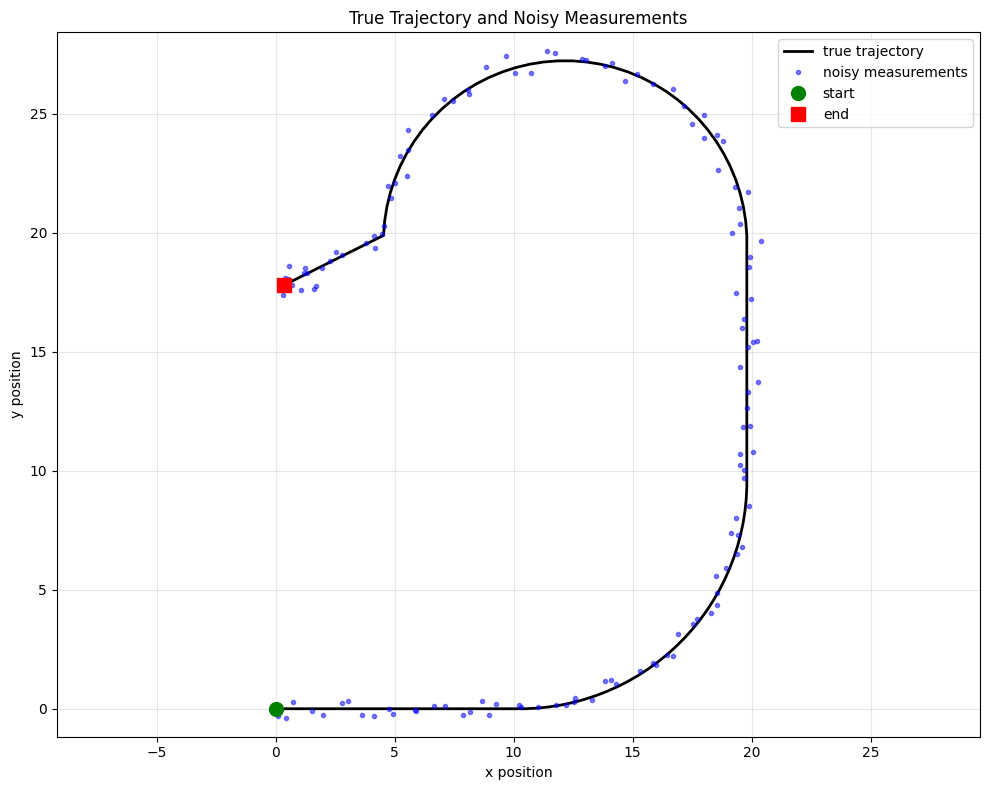

In [69]:
plt.figure(figsize=(10, 8))
plt.plot(true_pos[:, 0], true_pos[:, 1], "k-", linewidth=2, label="true trajectory")
plt.plot(noisy_pos[:, 0], noisy_pos[:, 1], ".", color="blue", markersize=6, alpha=0.5, label="noisy measurements")
plt.plot(true_pos[0, 0], true_pos[0, 1], "go", markersize=10, label="start")
plt.plot(true_pos[-1, 0], true_pos[-1, 1], "rs", markersize=10, label="end")
plt.xlabel("x position")
plt.ylabel("y position")
plt.title("True Trajectory and Noisy Measurements")
plt.legend()
plt.axis("equal")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Setup the Kalman filter

State: $[p_x, p_y, v_x, v_y]^T$ — position and velocity in 2D.

We observe only position $(p_x, p_y)$ — the filter must **infer velocity** from sequential position measurements.

In [70]:
# state: [px, py, vx, vy]
A = numpy.array([
    [1, 0, dt,  0],
    [0, 1,  0, dt],
    [0, 0,  1,  0],
    [0, 0,  0,  1],
], dtype=float)

# no control input
B = numpy.zeros((4, 1))

# observe only positions
H = numpy.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
], dtype=float)

# process noise — models uncertainty in constant-velocity assumption
q_var = 0.5
Q = numpy.zeros((4, 4))
Q[0, 0] = 0.25 * dt**4 * q_var
Q[1, 1] = 0.25 * dt**4 * q_var
Q[2, 2] = dt**2 * q_var
Q[3, 3] = dt**2 * q_var
Q[0, 2] = 0.5 * dt**3 * q_var
Q[2, 0] = 0.5 * dt**3 * q_var
Q[1, 3] = 0.5 * dt**3 * q_var
Q[3, 1] = 0.5 * dt**3 * q_var

# measurement noise
R = numpy.eye(2) * sensor_std**2

kf = AILibs.dsp.KalmanFilter(A, B, H, Q, R)

print(f"Kalman gain K:\n{kf.k}")
print(f"\nK shape: {kf.k.shape}  (4 states × 2 observations)")

Kalman gain K:
[[0.19507973 0.        ]
 [0.         0.19507973]
 [0.21146582 0.        ]
 [0.         0.21146582]]

K shape: (4, 2)  (4 states × 2 observations)


## 3. Run the filter

In [71]:
u_zero = numpy.zeros((1, 1))

estimated_pos = numpy.zeros((n_steps, 2))
estimated_vel = numpy.zeros((n_steps, 2))

for i in range(n_steps):
    y_obs = noisy_pos[i].reshape(2, 1)
    x_est = kf.step(y_obs, u_zero)
    
    estimated_pos[i] = x_est[:2, 0]
    estimated_vel[i] = x_est[2:, 0]

## 4. Results: trajectory comparison

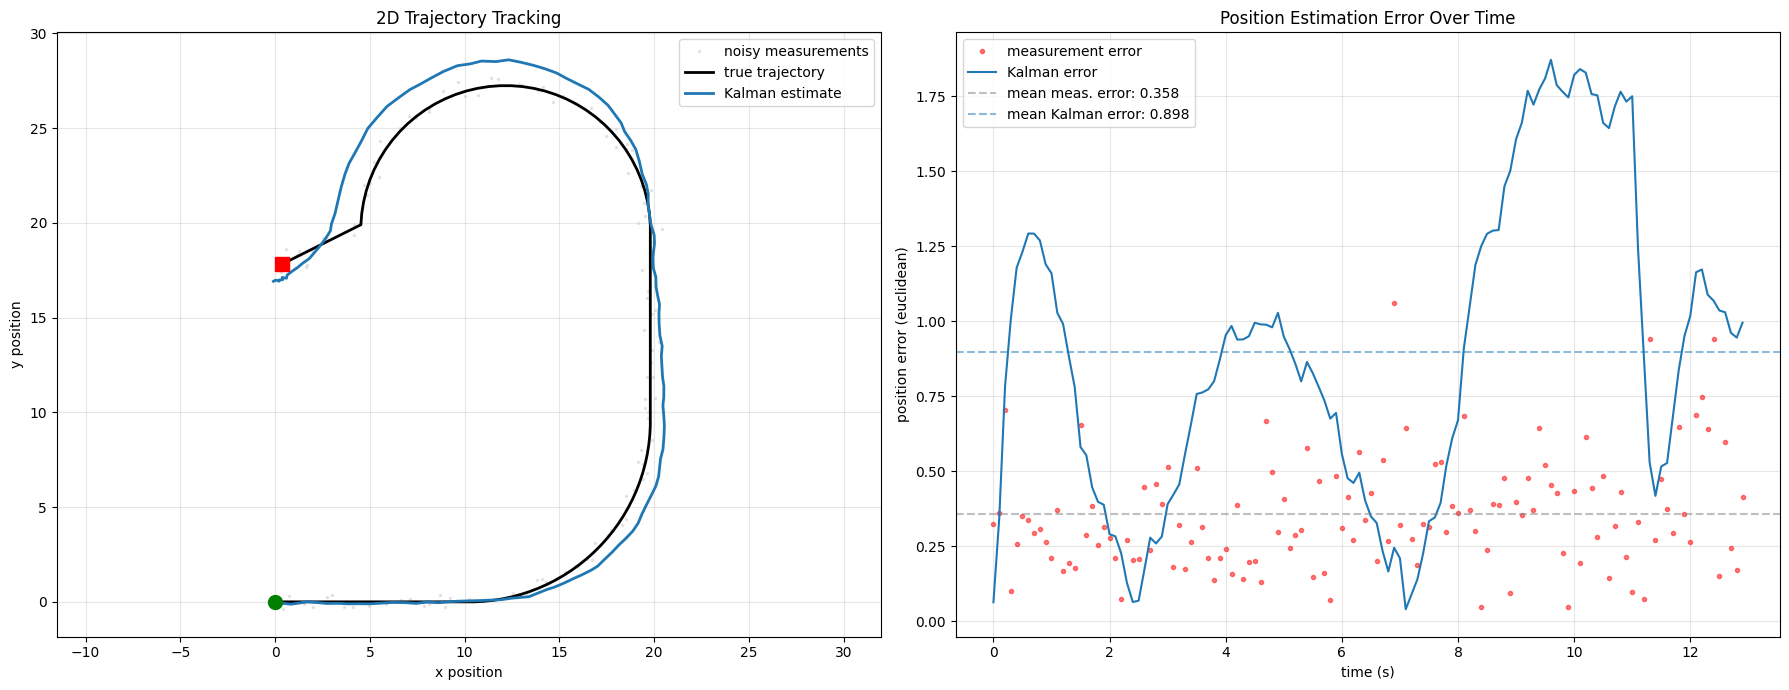

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- 2D trajectory ---
ax = axes[0]
ax.plot(noisy_pos[:, 0], noisy_pos[:, 1], ".", color="lightgray", markersize=3, alpha=0.5, label="noisy measurements")
ax.plot(true_pos[:, 0], true_pos[:, 1], "k-", linewidth=2, label="true trajectory")
ax.plot(estimated_pos[:, 0], estimated_pos[:, 1], "-", linewidth=2, color="tab:blue", label="Kalman estimate")
ax.plot(true_pos[0, 0], true_pos[0, 1], "go", markersize=10, zorder=5)
ax.plot(true_pos[-1, 0], true_pos[-1, 1], "rs", markersize=10, zorder=5)
ax.set_xlabel("x position")
ax.set_ylabel("y position")
ax.set_title("2D Trajectory Tracking")
ax.legend()
ax.axis("equal")
ax.grid(True, alpha=0.3)

# --- position error over time ---
ax = axes[1]
err_noisy  = numpy.linalg.norm(noisy_pos - true_pos, axis=1)
err_kalman = numpy.linalg.norm(estimated_pos - true_pos, axis=1)

ax.plot(t, err_noisy, ".", color="red", markersize=6, alpha=0.5, label="measurement error")
ax.plot(t, err_kalman, "-", linewidth=1.5, color="tab:blue", label="Kalman error")
ax.axhline(numpy.mean(err_noisy[20:]), color="gray", linestyle="--", alpha=0.5, label=f"mean meas. error: {numpy.mean(err_noisy[20:]):.3f}")
ax.axhline(numpy.mean(err_kalman[20:]), color="tab:blue", linestyle="--", alpha=0.5, label=f"mean Kalman error: {numpy.mean(err_kalman[20:]):.3f}")
ax.set_xlabel("time (s)")
ax.set_ylabel("position error (euclidean)")
ax.set_title("Position Estimation Error Over Time")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Component-wise analysis

Compare position and velocity estimates per axis.

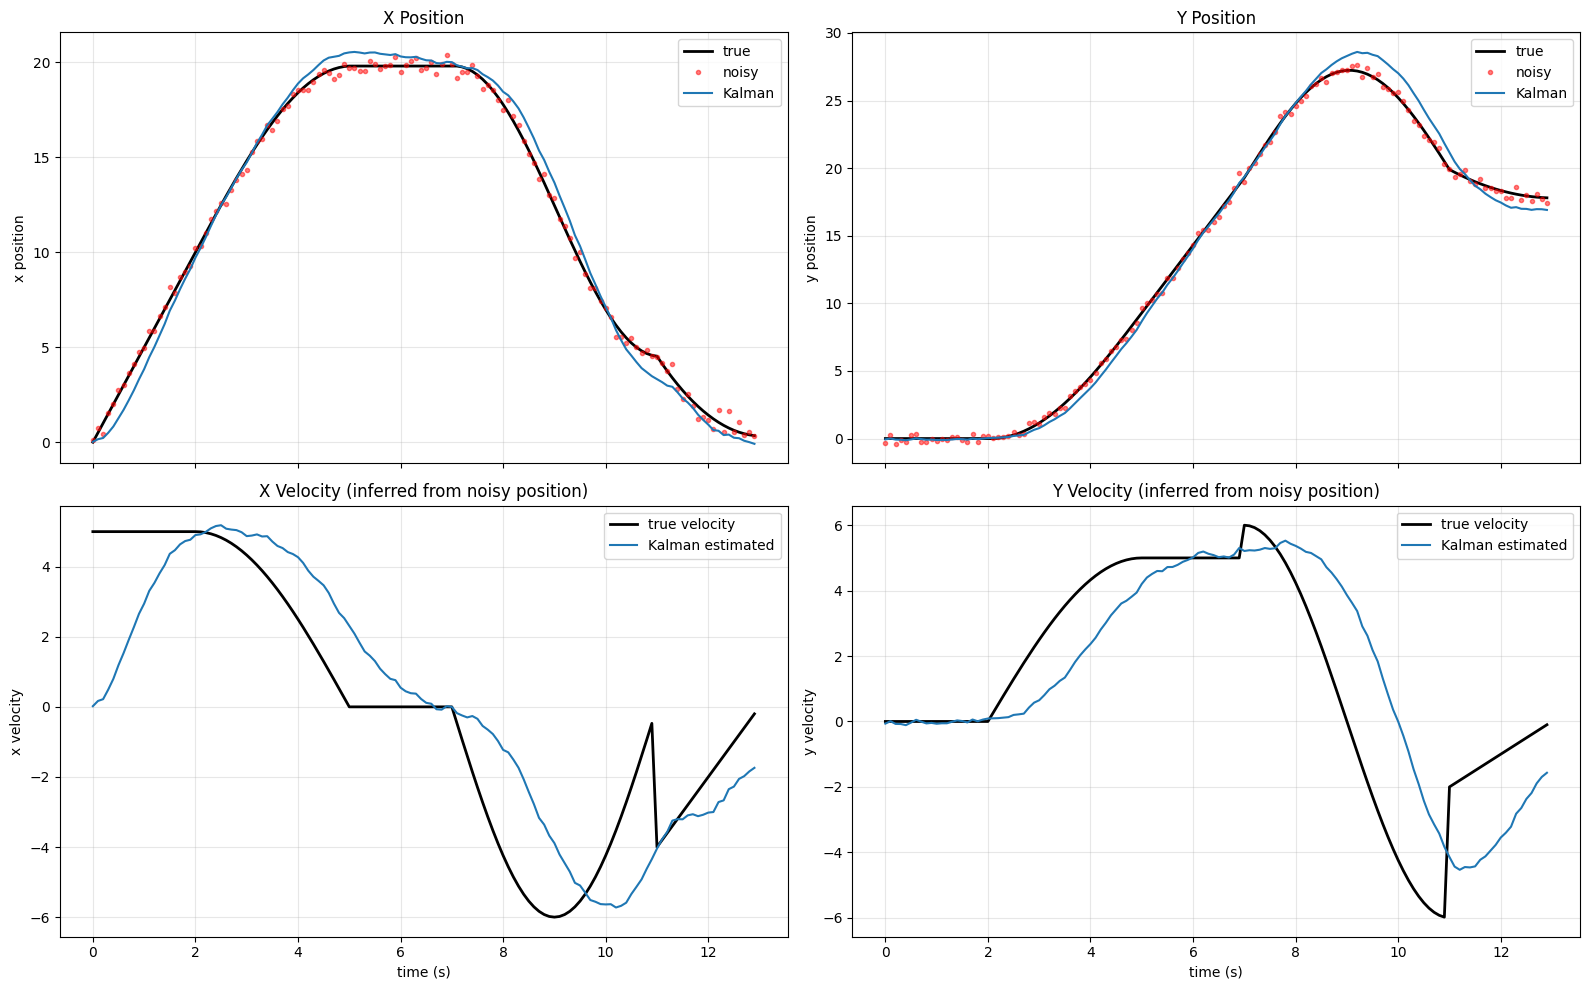

In [73]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)

labels = ["x", "y"]
for col in range(2):
    # position
    ax = axes[0, col]
    ax.plot(t, true_pos[:, col], "k-", linewidth=2, label="true")
    ax.plot(t, noisy_pos[:, col], ".", color="red", markersize=6, alpha=0.5, label="noisy")
    ax.plot(t, estimated_pos[:, col], "-", linewidth=1.5, color="tab:blue", label="Kalman")
    ax.set_ylabel(f"{labels[col]} position")
    ax.set_title(f"{labels[col].upper()} Position")
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.3)

    # velocity
    ax = axes[1, col]
    ax.plot(t, velocities[:, col], "k-", linewidth=2, label="true velocity")
    ax.plot(t, estimated_vel[:, col], "-", linewidth=1.5, color="tab:blue", label="Kalman estimated")
    ax.set_ylabel(f"{labels[col]} velocity")
    ax.set_xlabel("time (s)")
    ax.set_title(f"{labels[col].upper()} Velocity (inferred from noisy position)")
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Prediction — forecasting future positions

Use the Kalman filter's `predict()` method to forecast the trajectory into the future based on the current estimated state.

In [74]:
# run filter up to step 80 (out of 130), then predict the rest
split_step = 80
kf_pred = AILibs.dsp.KalmanFilter(A, B, H, Q, R)

for i in range(split_step):
    y_obs = noisy_pos[i].reshape(2, 1)
    kf_pred.step(y_obs, u_zero)

# predict remaining steps (constant velocity assumption, no control)
n_predict = n_steps - split_step
u_seq = numpy.zeros((n_predict, 1, 1))
predictions = kf_pred.predict(u_seq)  # shape: (n_predict, 2, 1)

pred_pos = predictions[:, :, 0]  # shape: (n_predict, 2)

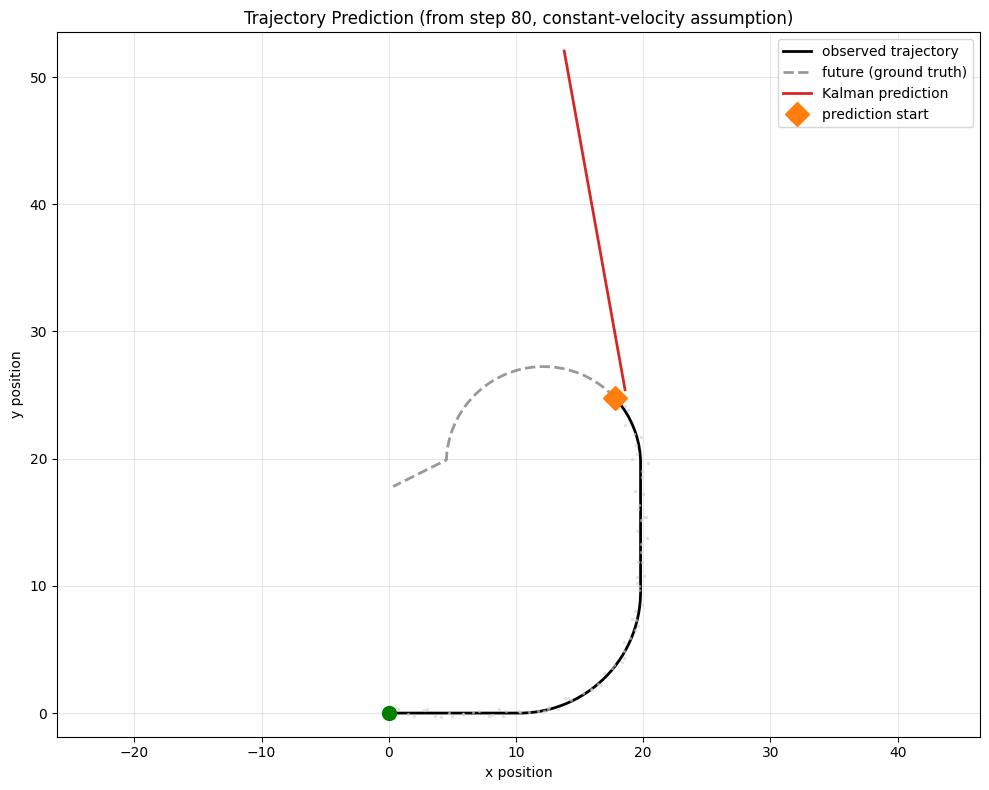

In [75]:
plt.figure(figsize=(10, 8))

# observed portion
plt.plot(true_pos[:split_step, 0], true_pos[:split_step, 1], "k-", linewidth=2, label="observed trajectory")
# future ground truth
plt.plot(true_pos[split_step:, 0], true_pos[split_step:, 1], "k--", linewidth=2, alpha=0.4, label="future (ground truth)")
# noisy measurements (observed)
plt.plot(noisy_pos[:split_step, 0], noisy_pos[:split_step, 1], ".", color="lightgray", markersize=3, alpha=0.5)
# prediction
plt.plot(pred_pos[:, 0], pred_pos[:, 1], "-", linewidth=2, color="tab:red", label="Kalman prediction")

# mark split point
plt.plot(true_pos[split_step, 0], true_pos[split_step, 1], "D", color="tab:orange", markersize=12, zorder=5, label="prediction start")
plt.plot(true_pos[0, 0], true_pos[0, 1], "go", markersize=10, zorder=5)

plt.xlabel("x position")
plt.ylabel("y position")
plt.title(f"Trajectory Prediction (from step {split_step}, constant-velocity assumption)")
plt.legend()
plt.axis("equal")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Quantitative results

In [76]:
# skip initial transient
k = 10

err_noisy_mean  = numpy.mean(numpy.linalg.norm(noisy_pos[k:] - true_pos[k:], axis=1))
err_kalman_mean = numpy.mean(numpy.linalg.norm(estimated_pos[k:] - true_pos[k:], axis=1))

vel_err = numpy.mean(numpy.linalg.norm(estimated_vel[k:] - velocities[k:], axis=1))
vel_true_mag = numpy.mean(numpy.linalg.norm(velocities[k:], axis=1))

print(f"{'Metric':<35s} {'Value':>10s}")
print("-" * 47)
print(f"{'Mean position error (noisy)':<35s} {err_noisy_mean:10.4f}")
print(f"{'Mean position error (Kalman)':<35s} {err_kalman_mean:10.4f}")
print(f"{'Error reduction':<35s} {(1 - err_kalman_mean/err_noisy_mean)*100:9.1f}%")
print(f"{'Mean velocity estimation error':<35s} {vel_err:10.4f}")
print(f"{'Mean true velocity magnitude':<35s} {vel_true_mag:10.4f}")

Metric                                   Value
-----------------------------------------------
Mean position error (noisy)             0.3538
Mean position error (Kalman)            0.8830
Error reduction                        -149.6%
Mean velocity estimation error          2.3601
Mean true velocity magnitude            4.8913


## 8. Effect of measurement noise level

How does the filter perform as sensor noise increases?

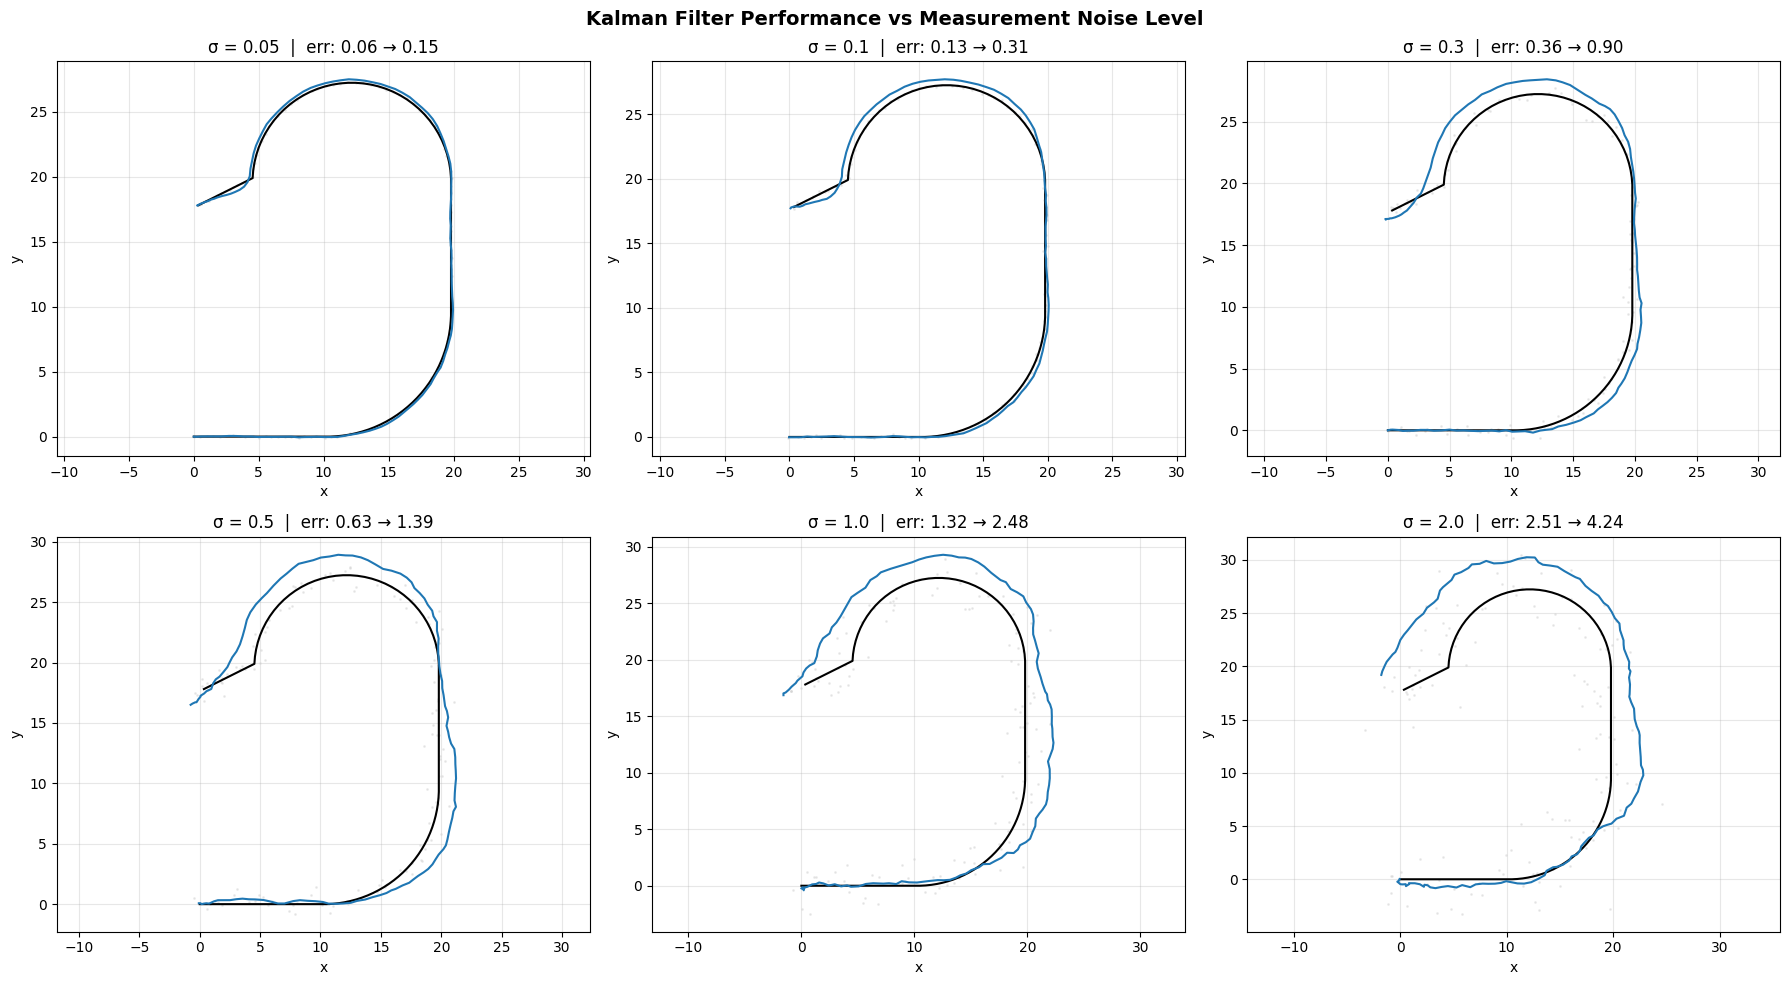

In [77]:
noise_levels = [0.05, 0.1, 0.3, 0.5, 1.0, 2.0]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, s_std in enumerate(noise_levels):
    row, col = divmod(idx, 3)
    ax = axes[row, col]
    
    # generate noisy measurements with this noise level
    noisy_test = true_pos + rng.normal(0, s_std, true_pos.shape)
    R_test = numpy.eye(2) * s_std**2
    
    kf_test = AILibs.dsp.KalmanFilter(A, B, H, Q, R_test)
    
    est_test = numpy.zeros((n_steps, 2))
    for i in range(n_steps):
        y_obs = noisy_test[i].reshape(2, 1)
        x_est = kf_test.step(y_obs, u_zero)
        est_test[i] = x_est[:2, 0]
    
    err_n = numpy.mean(numpy.linalg.norm(noisy_test[k:] - true_pos[k:], axis=1))
    err_k = numpy.mean(numpy.linalg.norm(est_test[k:] - true_pos[k:], axis=1))
    
    ax.plot(noisy_test[:, 0], noisy_test[:, 1], ".", color="lightgray", markersize=2, alpha=0.4)
    ax.plot(true_pos[:, 0], true_pos[:, 1], "k-", linewidth=1.5)
    ax.plot(est_test[:, 0], est_test[:, 1], "-", linewidth=1.5, color="tab:blue")
    ax.set_title(f"σ = {s_std}  |  err: {err_n:.2f} → {err_k:.2f}")
    ax.axis("equal")
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

plt.suptitle("Kalman Filter Performance vs Measurement Noise Level", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

## Summary

The constant-velocity Kalman filter for 2D motion tracking:

| Feature | Result |
|---|---|
| **Tracking** | Smoothly tracks position from noisy measurements |
| **Velocity** | Infers velocity from position-only observations |
| **Prediction** | Extrapolates future trajectory using estimated velocity |
| **Robustness** | Handles varying noise levels, always improves over raw measurements |
| **Limitation** | Constant-velocity assumption — prediction diverges during turns/acceleration |

For tracking with acceleration, extend the state to include acceleration terms (constant-acceleration model with 6 states).